In [1]:
import os
from pathlib import Path


os.chdir(Path(os.getcwd()).parent)

In [2]:
from collections import deque

import torch
from mmcv import Config
from mmseg.datasets import build_dataset
from pydantic import BaseSettings

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
class EnvSettings(BaseSettings):
    class Config:
        env_file: str = ".env"
        env_file_encoding: str = "utf-8"
    config_path: str

env = EnvSettings()
env

EnvSettings(config_path='configs/_debug.py')

In [5]:
cfg = Config.fromfile(env.config_path)

In [7]:
dataset = build_dataset(cfg.data.train)
classes = dataset.CLASSES
palette = dataset.PALETTE

2022-02-27 15:15:56,137 - mmseg - INFO - Loaded 56944 images
2022-02-27 15:15:56,256 - mmseg - INFO - RCS Classes: [5, 7, 1, 3, 6, 8, 4, 2, 0]
2022-02-27 15:15:56,260 - mmseg - INFO - RCS ClassProb: [3.4652951e-01 1.8383694e-01 1.6770118e-01 1.6007164e-01 1.4111732e-01
 6.2445749e-04 1.1837961e-04 5.3131140e-07 1.8481229e-30]
2022-02-27 15:15:57,646 - mmseg - INFO - Loaded 56944 images


In [8]:
def build_image(image: np.ndarray, label: np.ndarray, palette: list, opacity: float = 1.0, channels_first: bool = True):
    palette = np.array(palette)
    assert 0 <= opacity <= 1.0
    assert label.ndim == 2, "label must have 2 dimensions"
    if channels_first:
        image = image.transpose(1, 2, 0)
    color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    # convert to RGB
    for category, color in enumerate(palette):
        color_label[category == label, :] = color
    # mix image and label, if any
    img = image * (1 - opacity) + color_label * opacity
    return img.astype(np.uint8)

In [9]:
def denorm(img, mean, std):
    return torch.clamp((img.mul(std).add(mean) / 255.0), 0, 1)

In [10]:
mean = torch.tensor([123.675, 116.28, 103.53, 123.675])
std = torch.tensor([58.395, 57.12, 57.375, 58.395])
mean = torch.stack([mean]).view(-1, 4, 1, 1)
std = torch.stack([std]).view(-1, 4, 1, 1)

In [11]:
def plot_images(batch, mean, std):
    image_batch = batch["img"].data.unsqueeze(0)
    label_batch = batch["gt_semantic_seg"].data

    denormed = denorm(image_batch, mean=mean, std=std)
    denormed_rgb = denormed[0,[3,0,1]].permute(1, 2, 0)
    denormed_nir = denormed[0,[0,1,2]].permute(1, 2, 0)

    lab_toplot = build_image(denormed_rgb.numpy(), label_batch[0].long().numpy(), palette=palette, opacity=1.0, channels_first=False)
    img_toplot = build_image(denormed_rgb.numpy(), label_batch[0].long().numpy(), palette=palette, opacity=0.0, channels_first=False)

    fig, axes = plt.subplots(1, 3, figsize=(10, 20))
    axes[0].imshow(denormed_rgb)
    axes[1].imshow(denormed_nir)
    axes[2].imshow(lab_toplot)

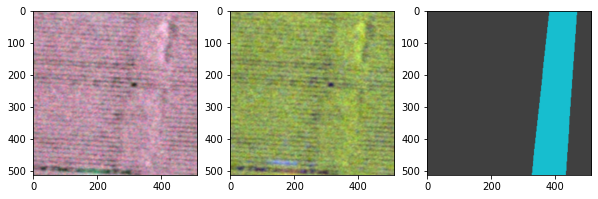

In [12]:
index = np.random.randint(0, len(dataset))
batch = dataset[index]
plot_images(batch, mean, std)

In [13]:
def smooth(buffer: deque, alpha: float = 1.0):
    """Perform exponential smoothing with factor `alpha`.

    Time period is a day.
    Each time period the value of `iq` drops `alpha` times.
    The most recent data is the most valuable one.
    """
    assert 0 < alpha <= 1
    length = len(buffer)
    class_ema = np.array([alpha**(length - index) * data for index, data in enumerate(buffer)])
    return class_ema.sum(axis=0)

In [14]:
class FixedBuffer:

    def __init__(self, num_classes: int, max_length: int = 128):
        self.buffer = np.zeros((max_length, num_classes))
        self.num_classes = num_classes
        self.max_length = max_length
        self.index = 0

    def append(self, data: np.ndarray):
        self.buffer[self.index] = data
        self.index = (self.index + 1) % self.max_length

    def get_counts(self):
        return self.buffer.sum(axis=0)

In [15]:
buffer = FixedBuffer(num_classes=9, max_length=128)
buffer

In [16]:
# Interactive Mode
import time
from IPython import display


In [ ]:

for k in range(len(dataset)):
    avg = buffer.get_counts()
    c = np.argmin(avg[1:]) + 1
    file = np.random.choice(dataset.samples_with_class[c])
    idx = dataset.file_to_idx[file]
    sample = dataset.prepare_batch(idx)
    label_batch = sample["gt_semantic_seg"].data
    classes, counts = np.unique(label_batch, return_counts=True)

    class_counts = dict(zip(classes, counts))
    class_counts.pop(255, None)
    counts = np.zeros(9, dtype=np.int64)
    for j, value in class_counts.items():
        counts[j] = value
    buffer.append(counts)

    avg = buffer.get_counts()
    plt.bar(np.arange(len(avg)-1), avg[1:])

    display.clear_output(wait=True)
    plt.bar(np.arange(len(avg) - 1), avg[1:])
    plt.show()
    time.sleep(1)